In [1]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = paddle.vision.datasets.MNIST(mode='train')

In [3]:
train_dataset

<Figure size 640x480 with 0 Axes>

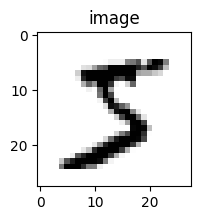

图像数据形状和对应数据为: (28, 28)
图像标签形状和对应数据为: (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [4]:
train_data_0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])

# 显示第一batch的第一个图像
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(2,2))
plt.imshow(train_data_0, cmap=plt.cm.binary)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

print("图像数据形状和对应数据为:", train_data_0.shape)
print("图像标签形状和对应数据为:", train_label_0.shape, train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))

In [5]:
# 定义mnist数据识别网络结构，同房价预测网络
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)
        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [6]:
# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

In [7]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[0, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img / 255
    # 将图像形式reshape为[batch_size, 784]
    img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

In [8]:
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    loss_list = []
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = norm_img(data[0]).astype('float32')
            labels = data[1].astype('float32')
            
            #前向计算的过程
            predicts = model(images)
            
            # 计算损失
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id % 1000 == 0:
                loss = avg_loss.numpy()[0]
                loss_list.append(loss)
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, loss))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
    
    return loss_list
            
loss_list = train(model)
paddle.save(model.state_dict(), './mnist.pdparams')

epoch_id: 0, batch_id: 0, loss is: 30.134899139404297
epoch_id: 0, batch_id: 1000, loss is: 4.904995918273926
epoch_id: 0, batch_id: 2000, loss is: 5.118741035461426
epoch_id: 0, batch_id: 3000, loss is: 2.7357053756713867
epoch_id: 1, batch_id: 0, loss is: 4.331856727600098
epoch_id: 1, batch_id: 1000, loss is: 1.5642260313034058
epoch_id: 1, batch_id: 2000, loss is: 4.229665279388428
epoch_id: 1, batch_id: 3000, loss is: 5.2443623542785645
epoch_id: 2, batch_id: 0, loss is: 3.8798294067382812
epoch_id: 2, batch_id: 1000, loss is: 5.133633613586426
epoch_id: 2, batch_id: 2000, loss is: 6.802003860473633
epoch_id: 2, batch_id: 3000, loss is: 4.626827716827393
epoch_id: 3, batch_id: 0, loss is: 4.453268527984619
epoch_id: 3, batch_id: 1000, loss is: 4.490059852600098
epoch_id: 3, batch_id: 2000, loss is: 2.0469062328338623
epoch_id: 3, batch_id: 3000, loss is: 2.842984914779663
epoch_id: 4, batch_id: 0, loss is: 5.203644752502441
epoch_id: 4, batch_id: 1000, loss is: 2.5402398109436035


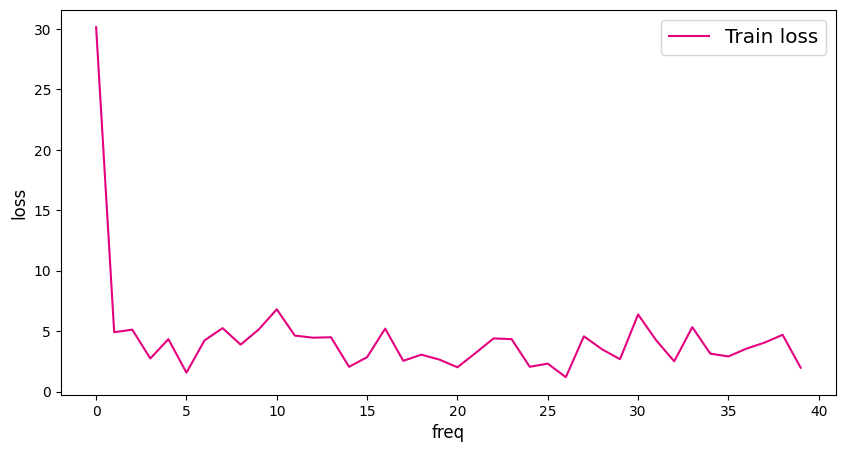

In [9]:
def plot(loss_list):
    plt.figure(figsize=(10,5))
    
    freqs = [i for i in range(len(loss_list))]
    # 绘制训练损失变化曲线
    plt.plot(freqs, loss_list, color='#e4007f', label="Train loss")
    
    # 绘制坐标轴和图例
    plt.ylabel("loss", fontsize='large')
    plt.xlabel("freq", fontsize='large')
    plt.legend(loc='upper right', fontsize='x-large')
    
    plt.show()

plot(loss_list)

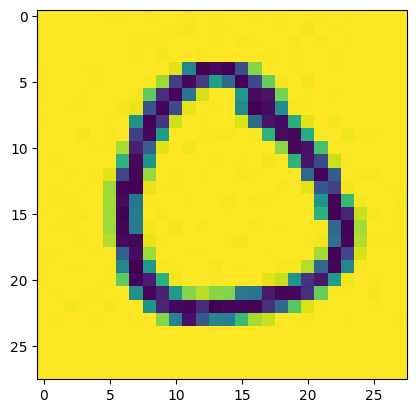

原始图像shape:  (28, 28)


C:\Users\gudeb\AppData\Local\Temp\ipykernel_13068\3712153676.py:15: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((28, 28), Image.ANTIALIAS)


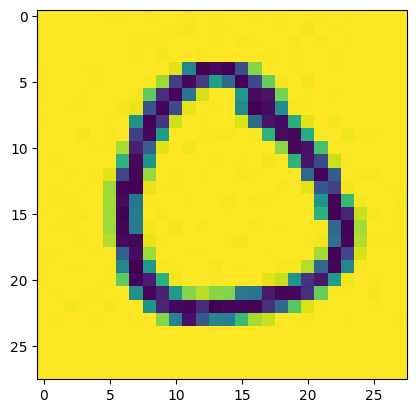

采样后图片shape:  (28, 28)


In [10]:
# 导入图像读取第三方库
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img_path = './work/example_0.jpg'
# 读取原始图像并显示
im = Image.open('./work/example_0.jpg')
plt.imshow(im)
plt.show()
# 将原始图像转为灰度图
im = im.convert('L')
print('原始图像shape: ', np.array(im).shape)
# 使用Image.ANTIALIAS方式采样原始图片
im = im.resize((28, 28), Image.ANTIALIAS)
plt.imshow(im)
plt.show()
print("采样后图片shape: ", np.array(im).shape)

In [11]:
# 读取一张本地的样例图片，转变成模型输入的格式
def load_image(img_path):
    # 从img_path中读取图像，并转为灰度图
    im = Image.open(img_path).convert('L')
    # print(np.array(im))
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, -1).astype(np.float32)
    # 图像归一化，保持和数据集的数据范围一致
    im = 1 - im / 255
    return im

# 定义预测过程
model = MNIST()
params_file_path = 'mnist.pdparams'
img_path = './work/example_0.jpg'
# 加载模型参数
param_dict = paddle.load(params_file_path)
model.load_dict(param_dict)
# 灌入数据
model.eval()
tensor_img = load_image(img_path)
result = model(paddle.to_tensor(tensor_img))
print('result',result)
#  预测输出取整，即为预测的数字，打印结果
print("本次预测的数字是", result.numpy().astype('int32'))

result Tensor(shape=[1, 1], dtype=float32, place=Place(cpu), stop_gradient=False,
       [[1.08814883]])
本次预测的数字是 [[1]]


C:\Users\gudeb\AppData\Local\Temp\ipykernel_13068\533195415.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((28, 28), Image.ANTIALIAS)


In [25]:
# 评估当前模型的准确率
def evaluate(model):
    y_true = []
    y_pred = []
    # 加载测试集
    test_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='test'),
                                        batch_size=16,shuffle=True)
    for batch_id, data in enumerate(test_loader()):
        images = norm_img(data[0]).astype('float32')
        labels = data[1].astype('float32')
        predicts = model(images)
        y_true.append(labels.numpy().astype('int32'))
        y_pred.append(predicts.numpy().astype('int32'))
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    acc = np.mean(np.equal(y_true, y_pred))
    return acc

loss_list = evaluate(model)
print("当前模型的准确率为: ", loss_list)

当前模型的准确率为:  0.2547


In [27]:
test_np = [[False],[True],[True],[False],[True],[True],[False],[True],[True],[False],[True],[True],[False],[True],[True],[False]]
# 总数
print(len(test_np))
# True的个数
print(np.sum(test_np))
# False的个数
print(len(test_np) - np.sum(test_np))
# 准确率
print(np.mean(test_np))

16
10
6
0.625
